In [4]:
# Login
import wrds
db = wrds.Connection(wrds_username="hanyuzhang")
# password is Timeseries2020!

Enter your WRDS username [liyf4]:hanyuzhang
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [5]:
# Preprocess Data
import pandas as pd
sym_df = pd.read_csv("Ticker.csv", header=0)
sym_list = sym_df["Ticker"].tolist()
sym_permno_list = list()
for symbol in sym_list:
    if len(symbol) == 0:
        continue
    result = db.raw_sql(f"""select permno, htsymbol 
                           from crsp.dsfhdr 
                           where htsymbol = '{symbol}'""")
    try:
        sym_permno_list.append((result.iloc[0]['permno'], result.iloc[0]['htsymbol']))
    except:
        print(f"wrds doesn't have data for {symbol} right now, skip...")

In [6]:
from collections import defaultdict
timeseries_bank = defaultdict(list)
for permno, symbol in sym_permno_list:
    result = db.raw_sql(f"""select date, prc, cfacpr
                            from crsp.dsf
                            where permno = {permno} and date > '2010-01-01'
                         """)
    ts = {date:prc for date, prc in zip(result["date"].tolist(), (result["prc"]/result["cfacpr"]).tolist())}
    if len(ts) != 0:
        timeseries_bank[symbol] = ts  

In [7]:
# Build pairs
sym_pairs = list()
sym_pairs_ts = dict()
valid_sym_list = list(timeseries_bank.keys())
for i in range(len(valid_sym_list)-1):
    for j in range(i+1, len(valid_sym_list)):
        sym_pairs.append((valid_sym_list[i], valid_sym_list[j]))
for pair in sym_pairs:
    sym_pairs_ts[pair] = {"first":timeseries_bank[pair[0]], "second":timeseries_bank[pair[1]]}
    
# sym_paris_ts is the pair timeseries:
# {(sym1, sym2):{'first':[(datetime.date(2010,1,1),price1), (datetime.date(2010,1,2):price2), ...}, "second":[...]}}

In [8]:
import numpy as np
import pandas as pd
import wrds
from collections import defaultdict
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation


def CointegrationTest(pairs, start_date, end_date, data):
    """
    pair: list of tuple
    date: datetime.date(YYYY,MM,DD)
    data: timeseries_bank
    """
    final_pairs = []
    for pair in pairs:
        timestamp = np.array(list(data[pair[0]].keys())).flatten()
        # print(pair,len(timestamp),len(list(data[pair[0]].values())),len(list(data[pair[1]].values())))
        t1 = np.log(
            np.array(list(data[pair[0]].values())).flatten()[(timestamp >= start_date) & (timestamp <= end_date)])
        t2 = np.log(
            np.array(list(data[pair[1]].values())).flatten()[(timestamp >= start_date) & (timestamp <= end_date)])

        t1 = t1 / t1[0]
        t2 = t2 / t2[0]

        result = coint_johansen(np.array([t1, t2]).T, det_order=0, k_ar_diff=1)
        if np.all(result.lr1 >= result.trace_stat_crit_vals[:, 0]):
            final_pairs.append(pair)
    return final_pairs


# functions for calcualting estimiated correlation matrix, inout of method "CorrelationTest"
func1=lambda w,V,numOfPC:V[:,:numOfPC].dot(np.diag(w[:numOfPC])).dot(V[:,:numOfPC].T)
func2=lambda w,V,numOfPC:V[:,:numOfPC].dot(np.diag(w[:numOfPC])).dot(V[:,:numOfPC].T)+\
                          sum(w[numOfPC:])/(len(w)-numOfPC)*(V[:,numOfPC:].dot(V[:,numOfPC:].T))


def CorrelationTest(pairs, start_date, end_date, data, numOfPC, func):
    """
    pair: list of tuple
    date: datetime.date(YYYY,MM,DD)
    data: timeseries_bank
    numOfCP: number of PC from evaluating correlation, we better has numOfPC<len(pairs)/2
    func: ways to calculate reduced corr
    """
    tickerList = []
    for pair in pairs:
        tickerList = tickerList + list(pair)
    tickerList = list(set(tickerList))

    raw_data = pd.DataFrame()
    timestamp = np.array(list(data[tickerList[0]].keys())).flatten()
    dateRange = (timestamp >= start_date) & (timestamp <= end_date)
    for ticker in tickerList:
        temp = np.array(list(data[ticker].values())).flatten()[dateRange]
        raw_data[ticker] = pd.Series(temp)
    return_data = np.log(1 + raw_data.pct_change().dropna())
    w, V = np.linalg.eig((return_data - return_data.mean()).cov())
    new_cov = func(w, V, numOfPC)
    new_corr = pd.DataFrame(correlation_from_covariance(new_cov), index=tickerList, columns=tickerList)
    ans = {}
    for pair in pairs:
        ans[pair] = new_corr.loc[pair[0], pair[1]]
    return ans


def OUCalibration(pairs, start_date, end_date, data):
    """
    pair: list of tuple
    date: datetime.date(YYYY,MM,DD)
    data: sym_pairs_ts
    """
    timestamp = np.array(list(data[pairs[0]]["first"].keys())).flatten()
    dateRange = (timestamp >= start_date) & (timestamp <= end_date)
    ans = {}
    deltat = 1 / 252
    for pair in pairs:
        t1 = np.log(np.array(list(data[pair]["first"].values())).flatten()[dateRange])
        t2 = np.log(np.array(list(data[pair]["second"].values())).flatten()[dateRange])

        t2_constant = sm.add_constant(t2)
        model2 = sm.OLS(t1, t2_constant)
        result2 = model2.fit()
        a1, b1 = result2.params
        #print(np.mean(result2.resid))

        Xt = t1 - a1 - b1 * t2
        y = Xt[1:]
        x = Xt[:-1]
        x = sm.add_constant(x)
        model = sm.OLS(y, x)
        results = model.fit()
        a, b = results.params
        std_residual = np.std(results.resid)

        theta = -np.log(b) / deltat
        mu = a / (1 - b)
        sigma = std_residual * np.sqrt(2 * theta / (1 - b ** 2))
        #print(mu)

        ans[pair] = {"half_life": np.log(2) / theta * 252, "mu": mu, "sigma": sigma / np.sqrt(2 * theta), "const": a1,
                     "coef": b1}

    return ans


In [273]:
# Back Test Framework
# utility function
import logging
from dateutil.relativedelta import relativedelta

logger = logging.getLogger()
logger.setLevel(logging.INFO)

def cal_spread(first, second, a1, b1)->float:
    return np.log(first) - a1 - b1 * np.log(second)


def pair_pnl(sym1, sym2, start_date, sigma, mean, half_life, a1, b1,all_pair,trading_cost=0.):
    
    numoftrade=0
    numofsucess=0
    numofdue=0
    numofstoploss=0
    numoflowcorr=0
    numofovertime=0
    numofwintrade=0
    
    open_price = 0
    close_price = 0
    open_value=0
    close_value=0
    returns=0
    growth=1
    
    opened = False
    open_date = None
    ls = True
    end_date = start_date + relativedelta(months=3)
    curr_date = start_date
    initial_corr = 0
    sym1_ts = timeseries_bank[sym1]
    sym2_ts = timeseries_bank[sym2]
    dateList=np.array(list(timeseries_bank[sym1].keys())).flatten()
    while curr_date < end_date:
        if curr_date not in sym1_ts or curr_date not in sym2_ts:
            curr_date += relativedelta(days=1)
            continue
        #change
        prev_date_idx=np.where(dateList==curr_date)[0][0]-1
        prev_date=dateList[prev_date_idx]
        
        spread = cal_spread(sym1_ts[curr_date], sym2_ts[curr_date], a1, b1)
        if spread > (mean+2*sigma) and (end_date - curr_date) > datetime.timedelta(days = 2 * half_life) and not opened:
            numoftrade+=1
            opened = True
            ls = True
            open_date = curr_date
            open_price = -sym1_ts[curr_date]*(1.0-trading_cost) + b1 * sym2_ts[curr_date]*(1.0+trading_cost)
            open_value = b1 * sym2_ts[curr_date]*(1.0+trading_cost)
            close_value= sym1_ts[curr_date]*(1.0-trading_cost)
            initial_corr = CorrelationTest(all_pair, curr_date-relativedelta(years=1), curr_date, timeseries_bank, 5, func1)[(sym1, sym2)]
            logger.debug(f"Open pair trade S{sym1, sym2}L on {curr_date}, price at open is {open_price}")
        elif spread < (mean -2*sigma) and (end_date - curr_date) > datetime.timedelta(days = 2 * half_life) and not opened:
            numoftrade+=1
            opened = True
            ls = False
            open_date = curr_date
            open_price = sym1_ts[curr_date]*(1.0+trading_cost) - b1 * sym2_ts[curr_date]*(1.0-trading_cost)
            open_value=sym1_ts[curr_date]*(1.0+trading_cost)
            close_value=b1 * sym2_ts[curr_date]*(1.0-trading_cost)
            initial_corr = CorrelationTest(all_pair, curr_date-relativedelta(years=1), curr_date, timeseries_bank, 5, func1)[(sym1, sym2)]
            logger.debug(f"Open pair trade L{sym1, sym2}S on {curr_date}, price at open is {open_price}")
        # trade close
        if opened:
            curr_corr = CorrelationTest(all_pair, curr_date-relativedelta(years=1), curr_date, timeseries_bank, 5, func1)[(sym1, sym2)]
            if (((spread <= mean+2*sigma) and (spread >= mean-2*sigma) ) or 
                (curr_date - open_date) > datetime.timedelta(days = 10*int(half_life)) or 
                (curr_corr < initial_corr*0.8) or 
                ((spread >= mean+3*sigma) and (spread <= mean-3*sigma) )):
                if ((spread <= mean+2*sigma) and (spread >= mean-2*sigma)):
                    numofsucess+=1
                    print((sym1,sym2),"Sucessfully close")
                elif ((spread >= mean+3*sigma) and (spread <= mean-3*sigma) ):
                    numofstoploss+=1
                    print((sym1,sym2),"fail close,stop loss here")
                elif (curr_date - open_date) > datetime.timedelta(days = 10 *int(half_life)):
                    numofovertime+=1
                    print((sym1,sym2),"fail close, reach 3*half-life")
                else:
                    print((sym1,sym2),"fail close, lower correlation")
                    numoflowcorr+=1
                      
                if ls:
                    close_price = -sym1_ts[curr_date]*(1+trading_cost) + b1 * sym2_ts[curr_date]*(1-trading_cost)
                    close_value+=(b1 * sym2_ts[curr_date]*(1-trading_cost)-sym1_ts[curr_date]*(1+trading_cost))
                    growth*=(close_value/open_value)
                    returns+=(close_price-open_price)
                    if (close_price-open_price)>0:
                        numofwintrade+=1
                    logger.debug(f"Close pair trade S{sym1, sym2}L on {curr_date}, price at close is {close_price}")
                else:
                    close_price = sym1_ts[curr_date]*(1-trading_cost) - b1 * sym2_ts[curr_date]*(1+trading_cost)
                    close_value+=(sym1_ts[curr_date]*(1-trading_cost) - b1 * sym2_ts[curr_date]*(1+trading_cost))
                    growth*=(close_value/open_value)
                    returns+=(close_price-open_price)
                    if (close_price-open_price)>0:
                        numofwintrade+=1
                    logger.debug(f"Close pair trade L{sym1, sym2}S on {curr_date}, price at close is {close_price}")
                opened = False
                break
        curr_date += relativedelta(days=1)
    if opened:
        print((sym1,sym2),"fail close,time is due")
        numofdue+=1
        curr_date -= relativedelta(days=1)
        while curr_date not in sym1_ts:
            curr_date -= relativedelta(days=1)
        if ls:
            close_price = (-sym1_ts[curr_date] + b1 * sym2_ts[curr_date])*(1-trading_cost)
            returns+=(close_price-open_price)
            growth*=(close_value/open_value)
            if (close_price-open_price)>0:
                numofwintrade+=1
        else:
            close_price = (sym1_ts[curr_date] - b1 * sym2_ts[curr_date])*(1-trading_cost)
            returns+=(close_price-open_price)
            growth*=(close_value/open_value)
            if (close_price-open_price)>0:
                numofwintrade+=1
        logger.debug(f"Close pair trade {sym1, sym2} on {curr_date}, price at close is {close_price}")
        opened = False
    return returns,growth-1,{"TotalTrade":numoftrade,"Success":numofsucess,"Due":numofdue,"Halflife":numofovertime,
                                      "Corr":numoflowcorr,"Stoploss":numofstoploss,"WinTrade":numofwintrade}

def pnl_wrapper(quarter, verbose=False,corr_bench=0.0,trading_cost=0.0):
    return_summary={}
    return_rate_list=[]
    quarterly_stats={"TotalTrade":0,"Success":0,"Due":0,"Halflife":0,
                                      "Corr":0,"Stoploss":0,"WinTrade":0}
    for pair in sym_pairs:
        return_summary[pair]=0.
    total_pnl = 0
    end_date = quarter - relativedelta(days=1)
    start_date = quarter - relativedelta(years=1)
    # pair selection
    post_coint_pairs = CointegrationTest(sym_pairs, start_date, end_date, timeseries_bank)
    pair_corr = CorrelationTest(post_coint_pairs, start_date, end_date, timeseries_bank, 5, func2)
    post_corr_pairs = list()
    for pair, corr in pair_corr.items():
        if corr > corr_bench:
            post_corr_pairs.append(pair)
    if len(post_corr_pairs)>0:
        pair_params = OUCalibration(post_corr_pairs, start_date, end_date, sym_pairs_ts)
        for pair, params in pair_params.items():
            pair_result,return_rate,stats=pair_pnl(pair[0], pair[1], quarter, params["sigma"], params["mu"],
                                  params["half_life"], params["const"], params["coef"],post_corr_pairs,trading_cost)
            for key,value in stats.items():
                quarterly_stats[key]=quarterly_stats[key]+value

            print(pair,"quarterly earn:",pair_result)
            return_rate_list.append(return_rate)
            total_pnl += pair_result
            return_summary[pair]=pair_result
        
    logger.info(f"total pnl for quarter {quarter} is {total_pnl}")
    
    return total_pnl,return_summary,quarterly_stats,return_rate_list


def full_test(start_date, corr_bench=0.0,trading_cost=0.0,verbose=False):
    import matplotlib.pyplot as plt
    summary={}
    stats=[]
    total_return_rate=[]
    date_track=[]
    for pair in sym_pairs:
        summary[pair]=0
    if verbose:
        logger.setLevel(logging.DEBUG)
    else:
        logger.setLevel(logging.INFO)
    quarters = list()
    pnls = list()
    curr_date = start_date
    while curr_date < datetime.date(2019, 12, 31):
        pnl,Rsummary,quarter_stats,quarter_return_rate=pnl_wrapper(curr_date,corr_bench=corr_bench,trading_cost=trading_cost)
        total_return_rate=total_return_rate+quarter_return_rate
        pnls.append(pnl)
        date_track.append(curr_date)
        quarters.append(curr_date)
        curr_date += relativedelta(months=3)
        for key,value in Rsummary.items():
            summary[key]=summary[key]+value
        stats.append(list(quarter_stats.values()))
            
    plt.plot(quarters, pnls)
    plt.show()
    plt.plot(np.cumsum(pnls))
    plt.show()
    
    return pnls,summary,stats,np.array(total_return_rate),date_track

('MSFT', 'JPM') fail close,time is due
('MSFT', 'JPM') quarterly earn: -2.757631072557494
('JPM', 'WFC') Sucessfully close
('JPM', 'WFC') quarterly earn: 1.3823941079427513
('JPM', 'GE') quarterly earn: 0
('JPM', 'LLY') Sucessfully close
('JPM', 'LLY') quarterly earn: 0.9793080904906049
('JPM', 'PEP') Sucessfully close
('JPM', 'PEP') quarterly earn: 0.4821912406154283
('JPM', 'BA') Sucessfully close
('JPM', 'BA') quarterly earn: 0.8356015780319694
('JNJ', 'WMT') Sucessfully close
('JNJ', 'WMT') quarterly earn: 0.7275352867722731
('JNJ', 'ABT') quarterly earn: 0
('JNJ', 'LLY') quarterly earn: 0
('JNJ', 'BA') quarterly earn: 0
('WMT', 'BA') Sucessfully close
('WMT', 'BA') quarterly earn: 0.5953125918152153
('ADBE', 'PEP') quarterly earn: 0
('ADBE', 'BA') quarterly earn: 0
('MMM', 'LLY') Sucessfully close
('MMM', 'LLY') quarterly earn: 0.7671278654260831
('MMM', 'PEP') fail close,time is due
('MMM', 'PEP') quarterly earn: -3.277733471469567
('MMM', 'BA') Sucessfully close
('MMM', 'BA') qu

('XOM', 'UNH') quarterly earn: 0
('XOM', 'GE') Sucessfully close
('XOM', 'GE') quarterly earn: 0.9680643998353702
('XOM', 'MO') quarterly earn: 0
('XOM', 'BA') quarterly earn: 0
('WFC', 'UNH') Sucessfully close
('WFC', 'UNH') quarterly earn: 0.42451309882095956
('WFC', 'BA') fail close,time is due
('WFC', 'BA') quarterly earn: -3.1788903318012984
('UNH', 'BA') quarterly earn: 0
('CVX', 'MO') quarterly earn: 0
('MMM', 'BA') fail close, lower correlation
('MMM', 'BA') quarterly earn: -6.537358279696022
('GE', 'BA') Sucessfully close
('GE', 'BA') quarterly earn: 0.6932651528932539
('MO', 'KO') Sucessfully close
('MO', 'KO') quarterly earn: 0.5724570531991446
('MO', 'PEP') fail close,time is due
('MO', 'PEP') quarterly earn: -3.47479694490508
('MO', 'BA') quarterly earn: 0
('KO', 'PEP') Sucessfully close
('KO', 'PEP') quarterly earn: -0.0333146496980703
('KO', 'BA') fail close,time is due
('KO', 'BA') quarterly earn: -4.477824562699851
('WMT', 'KO') quarterly earn: 0
('MO', 'KO') Sucessful

('JPM', 'ADBE') Sucessfully close
('JPM', 'ADBE') quarterly earn: 0.1791300597500154
('JPM', 'HON') Sucessfully close
('JPM', 'HON') quarterly earn: 0.0005310105273181875
('JPM', 'GE') Sucessfully close
('JPM', 'GE') quarterly earn: 1.3986815229179257
('JPM', 'ABT') Sucessfully close
('JPM', 'ABT') quarterly earn: 0.5690501687882232
('JPM', 'KO') Sucessfully close
('JPM', 'KO') quarterly earn: 0.8792824925909883
('JPM', 'PEP') Sucessfully close
('JPM', 'PEP') quarterly earn: 0.8591516072837351
('JNJ', 'WMT') quarterly earn: 0
('JNJ', 'GE') Sucessfully close
('JNJ', 'GE') quarterly earn: 0.8802261372627669
('JNJ', 'KO') quarterly earn: 0
('WFC', 'ADBE') Sucessfully close
('WFC', 'ADBE') quarterly earn: 0.9566287008249219
('WFC', 'GE') Sucessfully close
('WFC', 'GE') quarterly earn: 0.0846690003491446
('WFC', 'ABT') quarterly earn: 0
('WFC', 'KO') Sucessfully close
('WFC', 'KO') quarterly earn: 0.33871955731066805
('WFC', 'PEP') fail close, lower correlation
('WFC', 'PEP') quarterly earn

('JPM', 'BA') Sucessfully close
('JPM', 'BA') quarterly earn: 1.459960815047495
('JNJ', 'WFC') fail close,time is due
('JNJ', 'WFC') quarterly earn: -8.372327539797936
('JNJ', 'UNH') fail close,time is due
('JNJ', 'UNH') quarterly earn: -3.3619896142429155
('JNJ', 'ADBE') Sucessfully close
('JNJ', 'ADBE') quarterly earn: 1.1016396817568932
('JNJ', 'MDT') Sucessfully close
('JNJ', 'MDT') quarterly earn: 0.5141518116590191
('JNJ', 'HON') Sucessfully close
('JNJ', 'HON') quarterly earn: 2.987715952605562
('JNJ', 'GE') Sucessfully close
('JNJ', 'GE') quarterly earn: 0.6270707015573294
('JNJ', 'TXN') Sucessfully close
('JNJ', 'TXN') quarterly earn: 0.36866112916553107
('JNJ', 'LLY') Sucessfully close
('JNJ', 'LLY') quarterly earn: 0.7439367222743414
('JNJ', 'KO') Sucessfully close
('JNJ', 'KO') quarterly earn: 0.18270993227822885
('JNJ', 'PEP') Sucessfully close
('JNJ', 'PEP') quarterly earn: 1.4681306666957
('JNJ', 'BA') fail close, reach 3*half-life
('JNJ', 'BA') quarterly earn: -8.271764

('JNJ', 'LLY') quarterly earn: 0
('JNJ', 'KO') quarterly earn: 0
('JNJ', 'PEP') quarterly earn: 0
('XOM', 'WMT') Sucessfully close
('XOM', 'WMT') quarterly earn: 2.0570822064591994
('XOM', 'MMM') Sucessfully close
('XOM', 'MMM') quarterly earn: 1.200476481251215
('XOM', 'HON') Sucessfully close
('XOM', 'HON') quarterly earn: 0.7416774679574729
('XOM', 'GE') Sucessfully close
('XOM', 'GE') quarterly earn: 1.1384586677407853
('XOM', 'ABT') Sucessfully close
('XOM', 'ABT') quarterly earn: 0.09999145250252184
('XOM', 'LLY') quarterly earn: 0
('XOM', 'PEP') fail close,time is due
('XOM', 'PEP') quarterly earn: -4.688589824171672
('WFC', 'MMM') Sucessfully close
('WFC', 'MMM') quarterly earn: 0.4888099530096319
('WMT', 'MMM') fail close, lower correlation
('WMT', 'MMM') quarterly earn: -0.8383370498951876
('WMT', 'HON') fail close, lower correlation
('WMT', 'HON') quarterly earn: -1.7948987247735317
('WMT', 'GE') quarterly earn: 0
('WMT', 'ABT') Sucessfully close
('WMT', 'ABT') quarterly ear

('MMM', 'TXN') fail close,time is due
('MMM', 'TXN') quarterly earn: -24.612680922400898
('MMM', 'KO') Sucessfully close
('MMM', 'KO') quarterly earn: 26.868348798838582
('MMM', 'BA') fail close, lower correlation
('MMM', 'BA') quarterly earn: 28.722391556140963
('MO', 'KO') quarterly earn: 0
('MO', 'BA') quarterly earn: 0
('JPM', 'JNJ') quarterly earn: 0
('JPM', 'UNH') quarterly earn: 0
('JPM', 'MDT') quarterly earn: 0
('JPM', 'TXN') Sucessfully close
('JPM', 'TXN') quarterly earn: 1.9616708192068089
('JNJ', 'XOM') quarterly earn: 0
('JNJ', 'WFC') Sucessfully close
('JNJ', 'WFC') quarterly earn: 1.9226168953948104
('JNJ', 'UNH') quarterly earn: 0
('JNJ', 'CVX') Sucessfully close
('JNJ', 'CVX') quarterly earn: 2.399717327578287
('JNJ', 'MDT') fail close,time is due
('JNJ', 'MDT') quarterly earn: -6.707572238687774
('JNJ', 'TXN') Sucessfully close
('JNJ', 'TXN') quarterly earn: 2.6003458411261278
('JNJ', 'LLY') Sucessfully close
('JNJ', 'LLY') quarterly earn: 2.594894777289639
('JNJ', '

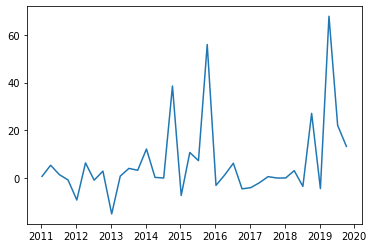

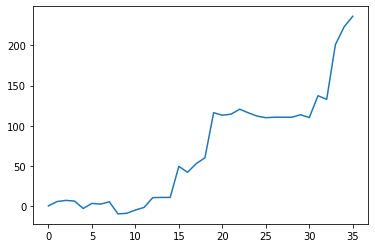

('MSFT', 'JPM') fail close,time is due
('MSFT', 'JPM') quarterly earn: -2.7837522570212094
('JPM', 'WFC') Sucessfully close
('JPM', 'WFC') quarterly earn: 1.3167766773065104
('JPM', 'GE') quarterly earn: 0
('JPM', 'LLY') Sucessfully close
('JPM', 'LLY') quarterly earn: 0.9054760108279787
('JPM', 'PEP') Sucessfully close
('JPM', 'PEP') quarterly earn: 0.39184266864675266
('JPM', 'BA') Sucessfully close
('JPM', 'BA') quarterly earn: 0.7545291290821936
('JNJ', 'WMT') Sucessfully close
('JNJ', 'WMT') quarterly earn: 0.6131411637418296
('JNJ', 'ABT') quarterly earn: 0
('JNJ', 'LLY') quarterly earn: 0
('JNJ', 'BA') quarterly earn: 0
('WMT', 'BA') Sucessfully close
('WMT', 'BA') quarterly earn: 0.5233796447400607
('ADBE', 'PEP') quarterly earn: 0
('ADBE', 'BA') quarterly earn: 0
('MMM', 'LLY') Sucessfully close
('MMM', 'LLY') quarterly earn: 0.6517409836330046
('MMM', 'PEP') fail close,time is due
('MMM', 'PEP') quarterly earn: -3.3319044121846204
('MMM', 'BA') Sucessfully close
('MMM', 'BA')

('XOM', 'UNH') quarterly earn: 0
('XOM', 'GE') Sucessfully close
('XOM', 'GE') quarterly earn: 0.8668824811891511
('XOM', 'MO') quarterly earn: 0
('XOM', 'BA') quarterly earn: 0
('WFC', 'UNH') Sucessfully close
('WFC', 'UNH') quarterly earn: 0.3716202261754127
('WFC', 'BA') fail close,time is due
('WFC', 'BA') quarterly earn: -3.1599977405647834
('UNH', 'BA') quarterly earn: 0
('CVX', 'MO') quarterly earn: 0
('MMM', 'BA') fail close, lower correlation
('MMM', 'BA') quarterly earn: -6.649783337251577
('GE', 'BA') Sucessfully close
('GE', 'BA') quarterly earn: 0.7033895425561667
('MO', 'KO') Sucessfully close
('MO', 'KO') quarterly earn: 0.4886309009921703
('MO', 'PEP') fail close,time is due
('MO', 'PEP') quarterly earn: -3.5073595456696935
('MO', 'BA') quarterly earn: 0
('KO', 'PEP') Sucessfully close
('KO', 'PEP') quarterly earn: -0.13571997911270728
('KO', 'BA') fail close,time is due
('KO', 'BA') quarterly earn: -4.437589168601079
('WMT', 'KO') quarterly earn: 0
('MO', 'KO') Sucessf

('JPM', 'ADBE') Sucessfully close
('JPM', 'ADBE') quarterly earn: 0.08476235385849407
('JPM', 'HON') Sucessfully close
('JPM', 'HON') quarterly earn: -0.11496764234633616
('JPM', 'GE') Sucessfully close
('JPM', 'GE') quarterly earn: 1.3388927884671915
('JPM', 'ABT') Sucessfully close
('JPM', 'ABT') quarterly earn: 0.48124823878784184
('JPM', 'KO') Sucessfully close
('JPM', 'KO') quarterly earn: 0.7941349173219976
('JPM', 'PEP') Sucessfully close
('JPM', 'PEP') quarterly earn: 0.7356830143221629
('JNJ', 'WMT') quarterly earn: 0
('JNJ', 'GE') Sucessfully close
('JNJ', 'GE') quarterly earn: 0.7746758741825346
('JNJ', 'KO') quarterly earn: 0
('WFC', 'ADBE') Sucessfully close
('WFC', 'ADBE') quarterly earn: 0.8626858214025361
('WFC', 'GE') Sucessfully close
('WFC', 'GE') quarterly earn: 0.03472457098865789
('WFC', 'ABT') quarterly earn: 0
('WFC', 'KO') Sucessfully close
('WFC', 'KO') quarterly earn: 0.2631358557369694
('WFC', 'PEP') fail close, lower correlation
('WFC', 'PEP') quarterly ear

('JPM', 'BA') Sucessfully close
('JPM', 'BA') quarterly earn: 1.3792606687843438
('JNJ', 'WFC') fail close,time is due
('JNJ', 'WFC') quarterly earn: -8.386485443145574
('JNJ', 'UNH') fail close,time is due
('JNJ', 'UNH') quarterly earn: -3.3429405540263275
('JNJ', 'ADBE') Sucessfully close
('JNJ', 'ADBE') quarterly earn: 0.9920061056957223
('JNJ', 'MDT') Sucessfully close
('JNJ', 'MDT') quarterly earn: 0.36346205632731454
('JNJ', 'HON') Sucessfully close
('JNJ', 'HON') quarterly earn: 2.821794282778839
('JNJ', 'GE') Sucessfully close
('JNJ', 'GE') quarterly earn: 0.5163223389541258
('JNJ', 'TXN') Sucessfully close
('JNJ', 'TXN') quarterly earn: 0.2511601450838157
('JNJ', 'LLY') Sucessfully close
('JNJ', 'LLY') quarterly earn: 0.6466121722710056
('JNJ', 'KO') Sucessfully close
('JNJ', 'KO') quarterly earn: 0.05667981539291134
('JNJ', 'PEP') Sucessfully close
('JNJ', 'PEP') quarterly earn: 1.2926136694668031
('JNJ', 'BA') fail close, reach 3*half-life
('JNJ', 'BA') quarterly earn: -8.42

('JNJ', 'MO') fail close, lower correlation
('JNJ', 'MO') quarterly earn: -4.148421348099035
('JNJ', 'LLY') quarterly earn: 0
('JNJ', 'KO') quarterly earn: 0
('JNJ', 'PEP') quarterly earn: 0
('XOM', 'WMT') Sucessfully close
('XOM', 'WMT') quarterly earn: 1.9088505338538226
('XOM', 'MMM') Sucessfully close
('XOM', 'MMM') quarterly earn: 0.9954539396356523
('XOM', 'HON') Sucessfully close
('XOM', 'HON') quarterly earn: 0.5533594752951956
('XOM', 'GE') Sucessfully close
('XOM', 'GE') quarterly earn: 1.0290252766083228
('XOM', 'ABT') Sucessfully close
('XOM', 'ABT') quarterly earn: 0.01396094733742359
('XOM', 'LLY') quarterly earn: 0
('XOM', 'PEP') fail close,time is due
('XOM', 'PEP') quarterly earn: -4.7677255326165096
('WFC', 'MMM') Sucessfully close
('WFC', 'MMM') quarterly earn: 0.40759733316282976
('WMT', 'MMM') fail close, lower correlation
('WMT', 'MMM') quarterly earn: -1.0074961953661585
('WMT', 'HON') fail close, lower correlation
('WMT', 'HON') quarterly earn: -1.93898632850391

('ADBE', 'BA') Sucessfully close
('ADBE', 'BA') quarterly earn: 0.5758736398140911
('MDT', 'MMM') Sucessfully close
('MDT', 'MMM') quarterly earn: 11.239234866351183
('MDT', 'TXN') quarterly earn: 0
('MMM', 'MO') Sucessfully close
('MMM', 'MO') quarterly earn: 25.87416747198924
('MMM', 'TXN') fail close,time is due
('MMM', 'TXN') quarterly earn: -24.791094583160373
('MMM', 'KO') Sucessfully close
('MMM', 'KO') quarterly earn: 26.66855529494552
('MMM', 'BA') fail close, lower correlation
('MMM', 'BA') quarterly earn: 28.439014278474076
('MO', 'KO') quarterly earn: 0
('MO', 'BA') quarterly earn: 0
('JPM', 'JNJ') quarterly earn: 0
('JPM', 'UNH') quarterly earn: 0
('JPM', 'MDT') quarterly earn: 0
('JPM', 'TXN') Sucessfully close
('JPM', 'TXN') quarterly earn: 1.8028711969246487
('JNJ', 'XOM') quarterly earn: 0
('JNJ', 'WFC') Sucessfully close
('JNJ', 'WFC') quarterly earn: 1.7956370395634451
('JNJ', 'UNH') quarterly earn: 0
('JNJ', 'CVX') Sucessfully close
('JNJ', 'CVX') quarterly earn: 2.

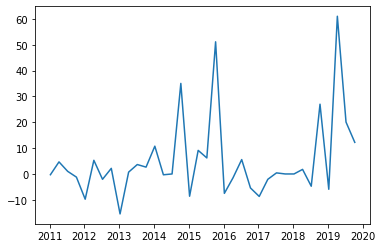

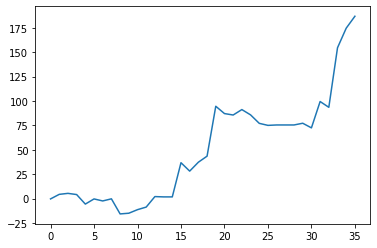

In [274]:
pnls_cost=[]
for cost in [0,0.0005]:
    pnls,summary,stats,rate,date_track=full_test(datetime.date(2011, 1, 10),corr_bench=bench,trading_cost=cost)
    pnls_corr.append(pnls)

In [277]:
pnls_corr[-2:]

[[0.6811077446419347,
  5.348712907616235,
  1.4404523790106651,
  -0.8335290228363057,
  -9.215196424147777,
  6.324908391324712,
  -0.8992931215208344,
  2.8796301185753244,
  -15.043885064051594,
  0.7894388833701598,
  4.031138760156274,
  3.2425677345803727,
  12.140967912233911,
  0.2553419620368018,
  0,
  38.52274812125463,
  -7.301327370356969,
  10.700870384280364,
  7.277794514686683,
  55.92575804851961,
  -3.0899099191700046,
  1.2615514901248872,
  6.187038673410196,
  -4.552588515431044,
  -4.021090220124602,
  -1.9782631697836734,
  0.5750276079755849,
  0,
  0,
  3.0807176447166,
  -3.503150835256207,
  27.09066702703595,
  -4.428161018506586,
  67.77098507494544,
  22.061441163587666,
  13.236076013406226],
 [-0.2961201819640813,
  4.671525316518167,
  1.0186285196134257,
  -1.2232784604356333,
  -9.7681629516259,
  5.285417460903254,
  -2.0677319938409653,
  2.168625280406072,
  -15.45992662028694,
  0.7118129855165094,
  3.647894885998852,
  2.6492496948002113,
  10

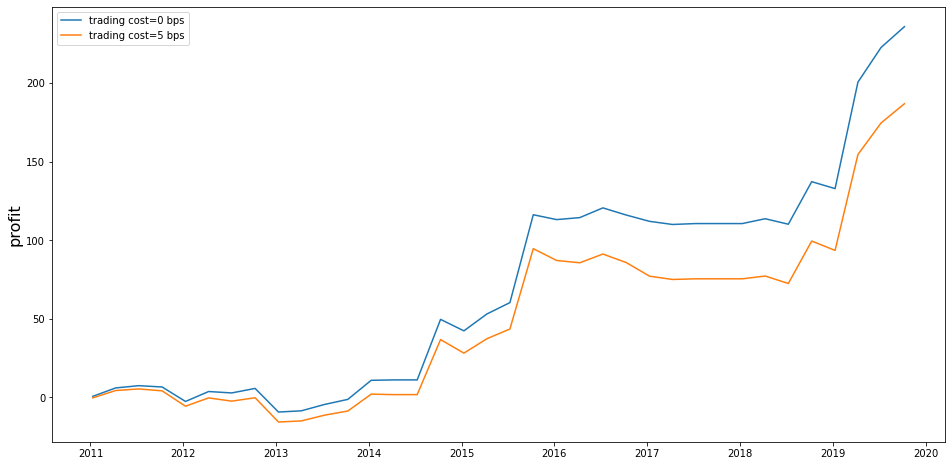

In [279]:
plt.figure(figsize=(16, 8))
for L,corr in zip(pnls_corr[-2:],["0 bps","5 bps"]):
    plt.plot(date_track,np.cumsum(L),label="trading cost={}".format(corr))
plt.legend()
plt.ylabel("profit",fontsize=16)
plt.legend()
plt.show()

In [283]:
np.cumsum(pnls_corr[-1])[-1]/np.cumsum(pnls_corr[-2])[-1]

0.7920936849891401

In [284]:
stats

[[12, 9, 3, 0, 0, 0, 9],
 [11, 10, 0, 0, 1, 0, 9],
 [7, 5, 2, 0, 0, 0, 5],
 [6, 5, 0, 1, 0, 0, 5],
 [12, 8, 2, 0, 2, 0, 7],
 [12, 12, 0, 0, 0, 0, 12],
 [11, 9, 1, 1, 0, 0, 10],
 [7, 6, 1, 0, 0, 0, 6],
 [9, 5, 3, 0, 1, 0, 4],
 [1, 1, 0, 0, 0, 0, 1],
 [4, 4, 0, 0, 0, 0, 3],
 [6, 3, 0, 0, 3, 0, 4],
 [10, 9, 1, 0, 0, 0, 6],
 [6, 3, 3, 0, 0, 0, 4],
 [0, 0, 0, 0, 0, 0, 0],
 [29, 27, 2, 0, 0, 0, 25],
 [14, 11, 1, 0, 2, 0, 11],
 [17, 16, 0, 0, 1, 0, 14],
 [9, 9, 0, 0, 0, 0, 6],
 [50, 38, 11, 0, 1, 0, 43],
 [42, 32, 7, 3, 0, 0, 32],
 [23, 19, 4, 0, 0, 0, 17],
 [7, 7, 0, 0, 0, 0, 7],
 [8, 7, 1, 0, 0, 0, 6],
 [27, 20, 3, 0, 4, 0, 18],
 [2, 1, 1, 0, 0, 0, 1],
 [1, 1, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [7, 7, 0, 0, 0, 0, 5],
 [8, 6, 1, 0, 1, 0, 6],
 [5, 4, 0, 0, 1, 0, 4],
 [6, 5, 1, 0, 0, 0, 3],
 [26, 18, 2, 1, 5, 0, 18],
 [13, 12, 1, 0, 0, 0, 12],
 [6, 6, 0, 0, 0, 0, 6]]

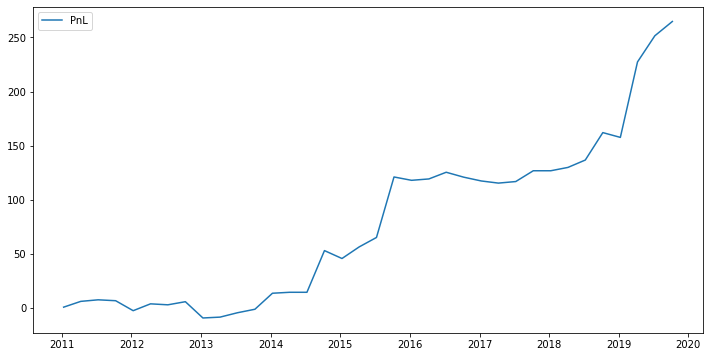

In [222]:
plt.figure(figsize=(12,6))
plt.plot(date_track,np.cumsum(pnls),label='PnL')
plt.legend()

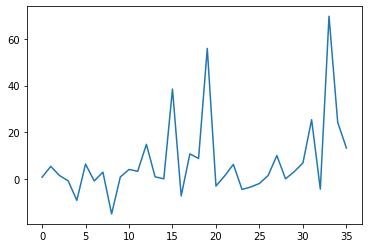

In [223]:
plt.plot(pnls)

In [224]:
np.cumsum(pnls)[-1]

264.74863959995326

In [237]:
ticker=list(timeseries_bank.keys())

In [238]:
df=pd.DataFrame(columns=ticker,index=ticker)

In [239]:
for t1 in ticker:
    for t2 in ticker:
        if t1!=t2:
            try:
                df.loc[t1,t2]=float(summary[(t1,t2)])
                df.loc[t2,t1]=float(summary[(t1,t2)])
            except:
                try:
                    df.loc[t1,t2]=float(summary[(t2,t1)])
                    df.loc[t2,t1]=float(summary[(t2,t1)])
                except:
                    raise ValueError("error")

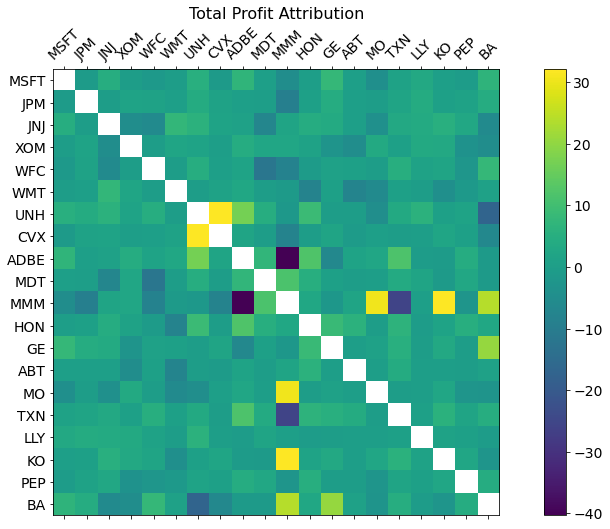

In [251]:
f = plt.figure(figsize=(16, 8))
plt.matshow(df.astype(float), fignum=f.number)
plt.xticks(range(len(ticker)), ticker, fontsize=14, rotation=45)
plt.yticks(range(len(ticker)), ticker, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Total Profit Attribution', fontsize=16)
plt.show()

In [252]:
corr_dict=CorrelationTest(list(sym_pairs_ts.keys()),datetime.date(2011,1,4),datetime.date(2019,12,31),timeseries_bank,5,func2)

In [254]:
corr_df=pd.DataFrame()
for t1 in ticker:
    for t2 in ticker:
        if t1!=t2:
            try:
                corr_df.loc[t1,t2]=float(corr_dict[(t1,t2)])
                corr_df.loc[t2,t1]=float(corr_dict[(t1,t2)])
            except:
                try:
                    corr_df.loc[t1,t2]=float(corr_dict[(t2,t1)])
                    corr_df.loc[t2,t1]=float(corr_dict[(t2,t1)])
                except:
                    raise ValueError("error")

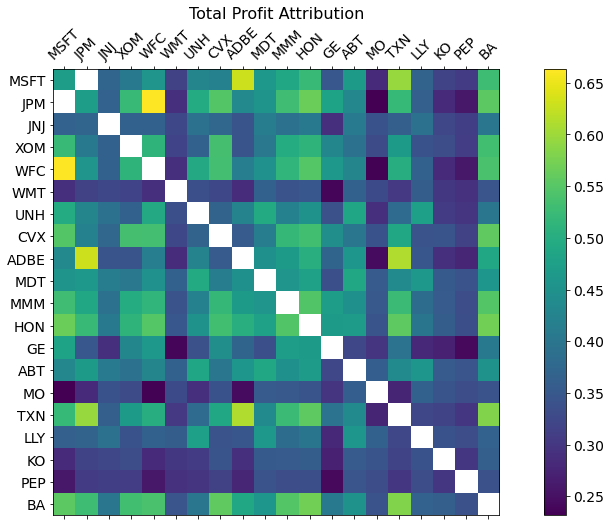

In [256]:
f = plt.figure(figsize=(16, 8))
plt.matshow(corr_df.astype(float), fignum=f.number)
plt.xticks(range(len(ticker)), ticker, fontsize=14, rotation=45)
plt.yticks(range(len(ticker)), ticker, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Total Profit Attribution', fontsize=16)
plt.show()

In [257]:
corr_df


,JPM,MSFT,JNJ,XOM,WFC,WMT,UNH,CVX,ADBE,MDT,MMM,HON,GE,ABT,MO,TXN,LLY,KO,PEP,BA
MSFT,0.472474,NaN,0.372424,0.406615,0.456625,0.316324,0.427980,0.421943,0.630632,0.462442,0.490279,0.522867,0.349364,0.466454,0.282899,0.596552,0.368970,0.320769,0.306266,0.528945
JPM,NaN,0.472474,0.367341,0.524402,0.663457,0.291652,0.496897,0.547487,0.435064,0.454824,0.530723,0.565651,0.482667,0.431459,0.231524,0.520484,0.363883,0.285382,0.258818,0.554228
JNJ,0.367341,0.372424,NaN,0.365210,0.365079,0.325832,0.394032,0.374322,0.344069,0.412105,0.394782,0.406921,0.290024,0.410286,0.340290,0.361887,0.392643,0.323132,0.311697,0.400477
XOM,0.524402,0.406615,0.365210,NaN,0.511815,0.317632,0.365732,0.535386,0.344028,0.405213,0.499530,0.512597,0.429249,0.392904,0.332679,0.466236,0.339948,0.333902,0.309533,0.532649
WFC,0.663457,0.456625,0.365079,0.511815,NaN,0.292225,0.492092,0.533789,0.416334,0.450125,0.516459,0.550191,0.461894,0.427370,0.234788,0.500214,0.366097,0.284527,0.259152,0.538797
WMT,0.291652,0.316324,0.325832,0.317632,0.292225,NaN,0.337265,0.324764,0.285606,0.365269,0.341899,0.348585,0.238842,0.366004,0.329037,0.303014,0.358215,0.301404,0.292529,0.346210
UNH,0.496897,0.427980,0.394032,0.365732,0.492092,0.337265,NaN,0.369288,0.424220,0.496148,0.421806,0.451807,0.338685,0.485518,0.290977,0.382446,0.475574,0.306802,0.295952,0.400647
CVX,0.547487,0.421943,0.374322,0.535386,0.533789,0.324764,0.369288,NaN,0.354835,0.413874,0.519804,0.533533,0.444428,0.400810,0.339782,0.489151,0.342310,0.343207,0.317358,0.558377
ADBE,0.435064,0.630632,0.344069,0.344028,0.416334,0.285606,0.424220,0.354835,NaN,0.449009,0.467225,0.502237,0.370979,0.458112,0.244369,0.612584,0.347468,0.290143,0.278091,0.488940
MDT,0.454824,0.462442,0.412105,0.405213,0.450125,0.365269,0.496148,0.413874,0.449009,NaN,0.455928,0.477861,0.336832,0.488450,0.355780,0.438349,0.461090,0.353923,0.341637,0.458260


<AxesSubplot:>

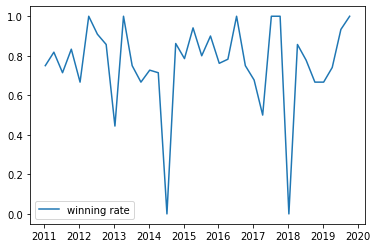

In [66]:
df[['winning rate']].plot()

<ipython-input-111-12f7023ad7db>:1: RuntimeWarning: invalid value encountered in true_divide
  df=pd.DataFrame({"Total Trade":stats[:,0],"Winning Trade":stats[:,1],"winning rate":stats[:,1]/stats[:,0]},index=date_track)


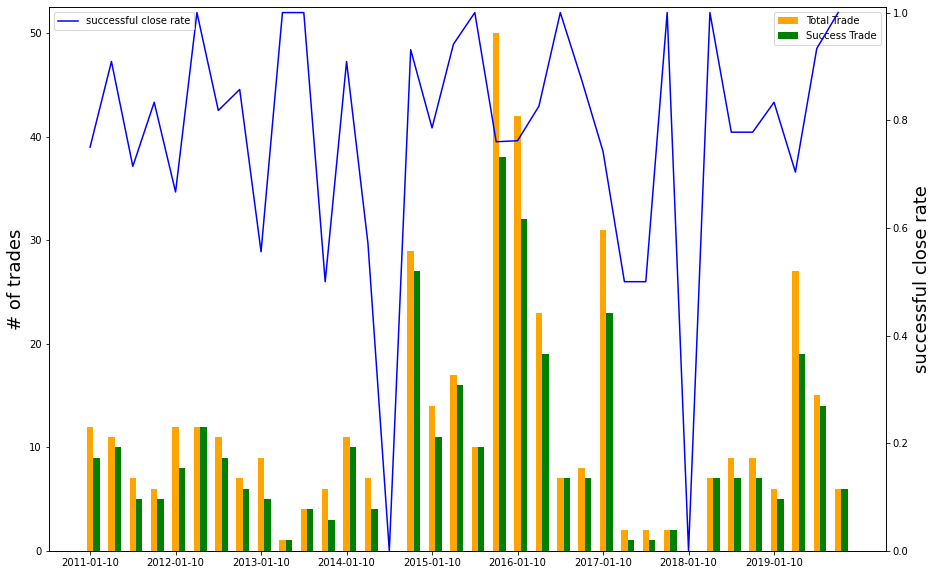

In [111]:
df=pd.DataFrame({"Total Trade":stats[:,0],"Winning Trade":stats[:,1],"winning rate":stats[:,1]/stats[:,0]},index=date_track)
df.fillna(0,inplace=True)

plt.figure(figsize=(15, 10)) 
width = 0.3
ind = np.arange(len(date_track))
plt.bar(ind, df["Total Trade"], width, color='orange',label="Total Trade")
plt.bar(ind+width, df["Winning Trade"], width, color='g', label="Success Trade")
plt.ylabel('# of trades',fontsize=18)
plt.legend()
axes2 = plt.twinx()
axes2.plot(ind, df["winning rate"], color='b', label='successful close rate')
axes2.set_ylim(0, 1.01)
axes2.set_ylabel('successful close rate',fontsize=18)
plt.legend()

plt.xticks(ind,date_track,fontsize=18)
plt.locator_params(axis='x', nbins=10)
plt.xlabel("time")
plt.show()

In [116]:
df=pd.DataFrame(stats)
df.index=date_track
df.columns=["TotalTrade","Success Trade",  " Closed Trade - time due"," Closed Trade - Halflife"," Closed Trade - lower corr"," Closed Trade - stop loss","Winning Trade"]

In [118]:
df=df[["TotalTrade","Winning Trade","Success Trade",  " Closed Trade - time due"," Closed Trade - Halflife"," Closed Trade - lower corr"," Closed Trade - stop loss"]]

In [119]:
df

,TotalTrade,Winning Trade,Success Trade,Closed Trade - time due,Closed Trade - Halflife,Closed Trade - lower corr,Closed Trade - stop loss
2011-01-10,12,9,9,3,0,0,0
2011-04-10,11,9,10,0,0,1,0
2011-07-10,7,5,5,2,0,0,0
2011-10-10,6,5,5,0,1,0,0
2012-01-10,12,8,8,2,0,2,0
2012-04-10,12,12,12,0,0,0,0
2012-07-10,11,10,9,1,1,0,0
2012-10-10,7,6,6,1,0,0,0
2013-01-10,9,4,5,3,0,1,0
2013-04-10,1,1,1,0,0,0,0


In [120]:
df.to_csv("trade_summary.csv")

In [144]:
df=pd.DataFrame(rate)

In [150]:
df.quantile(0.99)

0    4.971855
Name: 0.99, dtype: float64

In [151]:
df.quantile(0.01)

0   -4.865123
Name: 0.01, dtype: float64

In [204]:
a=0.99
b=1-a
df[(df < df.quantile(a)) & (df > df.quantile(b) )].describe().loc[["mean",'std']].values

array([[0.01158978],
       [0.42830911]])

In [211]:
sumdf=pd.DataFrame()
for a in [1,0.99,0.95,0.9,0.8]:
    mean,std=df[(df < df.quantile(a)) & (df > df.quantile(1-a) )].describe().loc[["mean",'std']].values.flatten()
    b=np.round(1-a,2)
    string=" {}<= quantile <= {}".format(b,a)
    mean=mean*4
    std=std*np.sqrt(4)
    sumdf[string]=[mean,std,(mean-0.0005)/std]

In [212]:
sumdf.index=["mean","std","Sharpe ratio"]

In [213]:
sumdf

,0<= quantile <= 1,0.01<= quantile <= 0.99,0.05<= quantile <= 0.95,0.1<= quantile <= 0.9,0.2<= quantile <= 0.8
mean,0.009731,0.046359,0.042602,0.031315,0.047444
std,3.620040,0.856618,0.065257,0.026054,0.013564
Sharpe ratio,0.002550,0.053535,0.645171,1.182743,3.460989


In [214]:
sumdf.T.to_csv("return_summary.csv")